# MAE 598 Project 1

Trying out multiple intitial states

### Code

In [1]:
# overhead

# import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import logging

logger = logging.getLogger(__name__)

In [2]:
# Environment parameters
dt = 0.5 # Time step (seconds)
g = 9.81e-3 # gravity constant (km / s^2)

# Specifications
L = 0.05 # Length of the vehicle (km)
l = 0.5 * L # Assumed position of CG along the length (km)
# l1 = l2 = L / 2

d = 0.009 # Diameter of the vehicle (km)

Md = 100. # Dry mass of the vehicle (Metric tonnes)
Mf = 1200. # Mass of the fuel (Metric tonnes)

M = Md + Mf # Initial weight of the vehicle (Metric tonnes)

T = 15. # Total thrust of the main booster (Metric-tonnes-km / s^2) - Converted from 15 MN
H = 0.5 # Net thrust of the side booster booster (Metric-tonnes-km / s^2) - Converted from 0.5 MN
phi = 0.35 # Thrust vectoring limit (rads) (20 deg)

D = 204. # Drag force constant, multiply by velocity to compute the force (kg / m)

ve = 6 * 3.28 # Exhaust velocity of the engines (km / s)
# Number of engines = 6 (3 vacuum + 3 sea level)


### Mulitple starts

In [3]:
# System Dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """       
        Units: km, metric tonnes, sec, rad
        
        state:
        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        state[5] = theta_dot (angular momentum)
        state[6] = mass
        
        
        action:
        action[0]: thrust (Main booster)
        action[1]: thrust_h (thrust side booster)
        action[2]: thrust_vectoring_angle (Main booster)
        """

        for i in range(state.shape[0]):
            
            T_inst = T * action[i, 0]
            H_inst = H * action[i, 1]
            phi_inst = phi * action[i, 2]
                       
            dMdt = T_inst / ve # Max fuel mass rate (Metric tonnes / s)

            # Compute accelerations
            # dvxdt = ((T_inst * (phi_inst * action[i, 2])) + H_inst + (D * (state[i, 2] ** 2))) / state[i, 6]
            dvxdt = ((T_inst * (phi_inst + state[i, 4])) + H_inst) / state[i, 6]

            dvydt = (((T_inst * (1 - phi_inst * state[i, 4])) - (H_inst * state[i, 4]) + (D * (state[i, 3] ** 2))) / state[i, 6]) - g
            dwdt = (6 * ((T_inst * phi_inst) - H_inst)) / (state[i, 6] * L)
            dMdt = T_inst / ve # Max fuel mass rate (Metric tonnes / s)
            
            # Construct step vectors
            dvxdt_step = t.tensor([[(dt**2), 0., dt, 0., 0., 0., 0.]]) * dvxdt
            dvydt_step = t.tensor([[0., (dt**2), 0., dt, 0., 0., 0.]]) * dvydt
            dwdt_step = t.tensor([[0., 0., 0., 0., (dt**2), dt, 0.]]) * dwdt
            dMdt_step = t.tensor([[0., 0., 0., 0., 0., 0., -dt]]) * dMdt
            
            delta = dvxdt_step + dvydt_step + dwdt_step + dMdt_step

            if i == 0:
                delta_batched = delta
                # print(delta_batched, i)
                
            else:
                delta_batched = t.cat((delta_batched, delta), dim=0)
                # print(delta_batched, i)
  
        # print(delta_batched)
        
        state = state + delta_batched
        
        
        # Update state
        step_mat = t.tensor([[1., 0., 0., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0., 0.],
                             [dt, 0., 1., 0., 0., 0., 0.],
                             [0., dt, 0., 1., 0., 0., 0.],
                             [0., 0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., dt, 1., 0.],
                             [0., 0., 0., 0., 0., 0., 1.]])
        
        state = t.matmul(state, step_mat)
        
        
#         noise = np.random.normal(0, 1, (state.shape[0], state.shape[1]))
        
#         state = state + 0.2 * noise
        
        # print(state.shape)

        return state
    
t.autograd.set_detect_anomaly(True)

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            # nn.Linear(dim_hidden, 2 * dim_hidden),
            # nn.Tanh(),
            # nn.Linear( 2 * dim_hidden, dim_hidden),
            # nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            # nn.ReLU(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Tanh()
            # nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        # print("Action: ", action)
        # print("Action dim: ", action.shape)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        batch_sz = 5
        bounds = np.array([[-0.1, 0.1], 
                           [5, 6], 
                           [0, 0], 
                           [0, 0], 
                           [0, 1.57],
                           [0, 0],
                           [M, M],]) # angle in rads
       
        state = t.tensor(np.random.uniform(bounds[:,0], bounds[:, 1], (batch_sz, bounds.shape[0])), requires_grad=False).float()
        print('Dim. state: ', state.shape)
        print('Initial state: ', state)
        return state
    
    
    def error(self, state):
        error = (1 * state[:, 0]**2 + 1 * (state[:, 1] - 0.5 * L)**2 + 1 * state[:, 2]**2 + 1 * state[:, 3]**2 + 1 * state[:, 4]**2 + 1 * state[:, 5]**2 + 1 * (state[:, 6] - Md)**2).mean()
        # error = t.nn.functional.normalize(state**2, dim=0).mean().sum()
        return error

In [6]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1)
        # self.optimizer = optim.Adam(self.parameters, lr=0.1)
        # self.optimizer = optim.SGD(self.parameters, lr=0.01)
        # self.optimizer = optim.SGD(self.parameters, lr=0.01, momentum=0.9)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.6f' % (epoch + 1, loss))
            
            self.visualize()
            # if epoch % 3 == 2:
            #     self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        print(data.shape)
        fig = plt.figure(figsize=(20, 5))       
        fig1 = plt.figure(figsize=(5, 5)) 
        ax1 = fig.add_subplot(161)
        ax2 = fig.add_subplot(162)
        ax3 = fig.add_subplot(163)
        ax4 = fig.add_subplot(164)
        ax5 = fig.add_subplot(165)
        ax6 = fig.add_subplot(166)
        ax7 = fig1.add_subplot(111)
        for i in range(data.shape[1]):
            x = data[:, i, 0]
            y = data[:, i, 1]

            vx = data[:, i, 2]
            vy = data[:, i, 3]
            
            theta = data[:, i, 4]
            omega = data[:, i, 5]
            
            mass = data[:, i, 6]
            
            ax1.plot(x, y)
            ax1.set_xlabel('[X]')
            ax1.set_ylabel('[Y]')
            
            ax7.plot(y)
            ax7.set_xlabel('[Time]')
            ax7.set_ylabel('[X]')
            # ax1.set_xlim(-0.5, 0.5)
            # ax1.set_ylim(0, 10)
            
            ax2.plot(vx)
            ax2.set_xlabel('[Time]')
            ax2.set_ylabel('[Vx]')
            # ax2.set_xlim(0, data.shape[0])
            # ax2.set_ylim(0, 100)
            
            ax3.plot(vy)
            ax3.set_xlabel('[Time]')
            ax3.set_ylabel('[Vy]')
            # ax3.set_xlim(0, data.shape[0])
            # ax3.set_ylim(0, 100)
            
            ax4.plot(theta)
            ax4.set_xlabel('[Time]')
            ax4.set_ylabel('[Theta]')
            # ax4.set_xlim(0, data.shape[0])
            # ax4.set_ylim(0, 100)
            
            ax5.plot(omega)
            ax5.set_xlabel('[Time]')
            ax5.set_ylabel('[Omega]')
            
            ax6.plot(mass)
            ax6.set_xlabel('[Time]')
            ax6.set_ylabel('[Mass]')
            
            
        plt.show()

Dim. state:  torch.Size([5, 5])
Initial state:  tensor([[ 0.4606, 14.5062,  0.0000,  0.0000,  1.2308],
        [-0.6479, 12.7192,  0.0000,  0.0000,  1.0164],
        [-0.8278, 13.6337,  0.0000,  0.0000,  1.3053],
        [-0.4053, 10.2473,  0.0000,  0.0000,  0.7630],
        [-0.6354, 12.8426,  0.0000,  0.0000,  1.1118]])
[1] loss: 81.089653
(250, 5, 5)


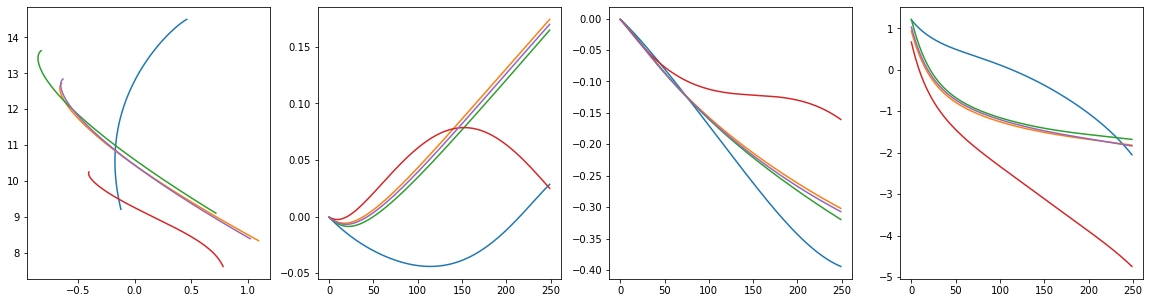

KeyboardInterrupt: 

In [7]:
# Now it's time to run the code!

T = 200  # number of time steps
dim_input = 7  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(10)  # solve the optimization problem
